In [1]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Grafiklerin notebook içinde daha güzel görünmesi için ayarlar
%matplotlib inline
plt.style.use('ggplot')

# Veriyi doğrudan internetten yükleme
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

# Verinin ilk 5 satırına göz atalım
print("Veri Setinin İlk 5 Satırı:")
display(df.head())

# Veri seti hakkında genel bilgi alalım
print("\nVeri Seti Bilgileri:")
df.info()

Veri Setinin İlk 5 Satırı:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Veri Seti Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  70

In [2]:
# TotalCharges sütunundaki boşluk karakterlerini sayısal değere çevirip, oluşan boşlukları doldurma
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Hedef değişkenimiz 'Churn' sütununu 0 ve 1'lere çevirme
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Kategorik verileri sayısal verilere dönüştürme (One-Hot Encoding)
# Müşteri ID'si model için anlamsız olduğu için onu çıkarıyoruz.
df_processed = pd.get_dummies(df.drop('customerID', axis=1), drop_first=True)

print("İşlenmiş Verinin İlk 5 Satırı:")
display(df_processed.head())

İşlenmiş Verinin İlk 5 Satırı:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


--- Keşifsel Veri Analizi ---


C:\Users\yldzy\AppData\Local\Temp\ipykernel_16488\159405445.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='viridis')


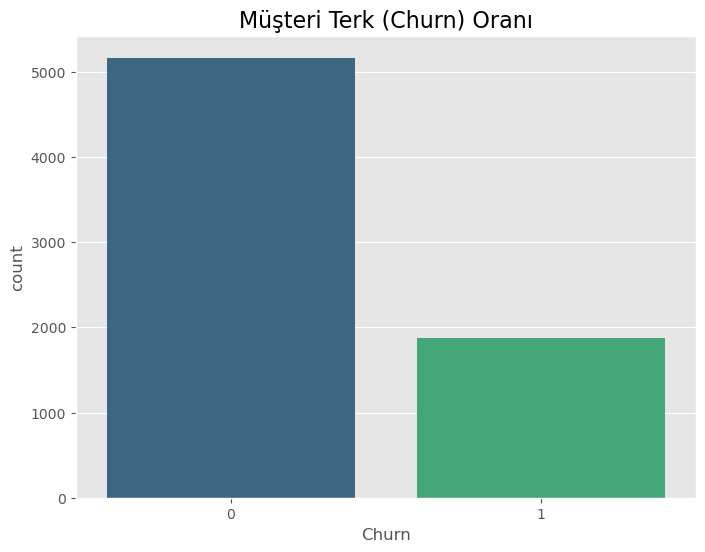

Yorum: Gördüğümüz gibi, verimizde 'Terk Etmeyen' (0) müşteri sayısı, 'Terk Eden' (1) müşteri sayısından çok daha fazla. Bu duruma 'dengesiz veri seti' denir ve model değerlendirmesi için önemlidir.


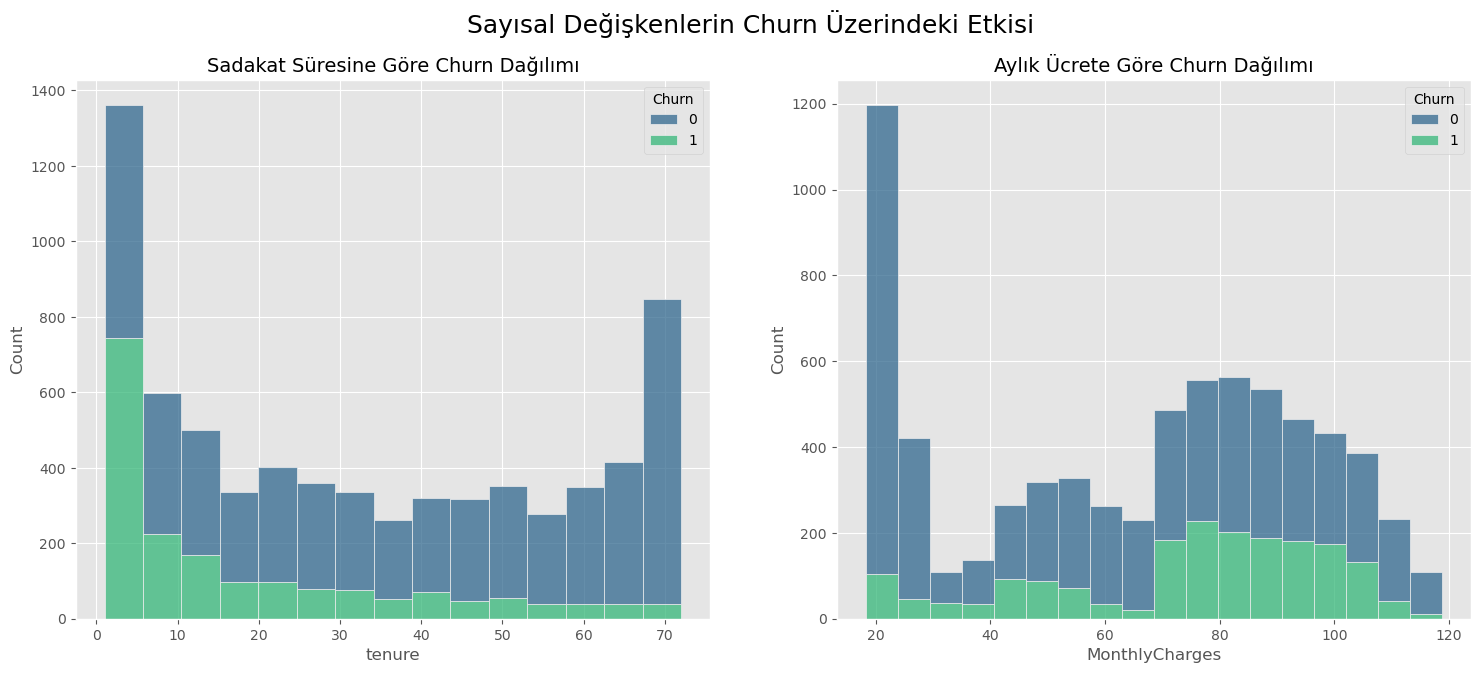

Yorum: İlk grafikten, 'tenure' (sadakat süresi) düşük olan müşterilerin (yeni müşteriler) daha çok terk ettiğini görüyoruz. İkinci grafikte ise 'MonthlyCharges' (aylık ücret) yüksek olan müşteriler arasında terk etme oranının daha fazla olduğu dikkat çekiyor.


In [3]:
print("--- Keşifsel Veri Analizi ---")

# 1. Churn Oranı Görselleştirmesi (Sınıf Dengesi)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Churn', palette='viridis')
plt.title('Müşteri Terk (Churn) Oranı', fontsize=16)
plt.show()
print("Yorum: Gördüğümüz gibi, verimizde 'Terk Etmeyen' (0) müşteri sayısı, 'Terk Eden' (1) müşteri sayısından çok daha fazla. Bu duruma 'dengesiz veri seti' denir ve model değerlendirmesi için önemlidir.")

# 2. Sadakat Süresi (tenure) ve Aylık Ödemelerin Churn'e Etkisi
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
plt.suptitle('Sayısal Değişkenlerin Churn Üzerindeki Etkisi', fontsize=18)

sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', ax=axes[0], palette='viridis')
axes[0].set_title('Sadakat Süresine Göre Churn Dağılımı', fontsize=14)

sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', ax=axes[1], palette='viridis')
axes[1].set_title('Aylık Ücrete Göre Churn Dağılımı', fontsize=14)
plt.show()
print("Yorum: İlk grafikten, 'tenure' (sadakat süresi) düşük olan müşterilerin (yeni müşteriler) daha çok terk ettiğini görüyoruz. İkinci grafikte ise 'MonthlyCharges' (aylık ücret) yüksek olan müşteriler arasında terk etme oranının daha fazla olduğu dikkat çekiyor.")

In [4]:
# Özellikleri (X) ve hedefi (y) ayırma
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Veriyi eğitim ve test setlerine ayırma
# stratify=y parametresi, dengesiz veri setinde churn oranını hem eğitim hem de test setinde korur.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Sayısal özellikleri ölçekleme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Model 1: Random Forest ---
print("\n--- Model 1: Random Forest Sonuçları ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# --- Model 2: XGBoost ---
print("\n--- Model 2: XGBoost Sonuçları ---")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


--- Model 1: Random Forest Sonuçları ---
Accuracy: 0.7882

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


--- Model 2: XGBoost Sonuçları ---
Accuracy: 0.7783

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.59      0.55      0.57       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407



C:\Users\yldzy\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:03:46] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\yldzy\AppData\Local\Temp\ipykernel_16488\387192772.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


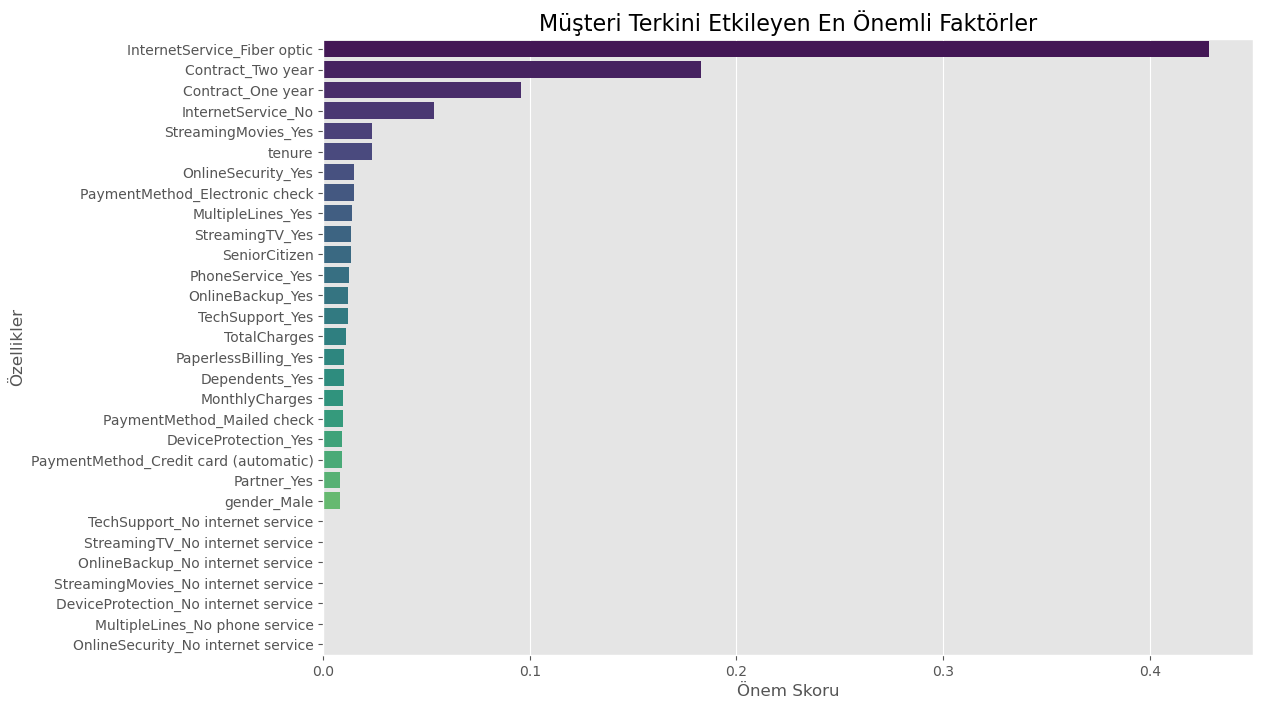

In [5]:
# XGBoost modelimizin özellik önem skorlarını alalım
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Bu skorları bir bar grafiği ile görselleştirelim
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
plt.title('Müşteri Terkini Etkileyen En Önemli Faktörler', fontsize=16)
plt.xlabel('Önem Skoru', fontsize=12)
plt.ylabel('Özellikler', fontsize=12)
plt.show()

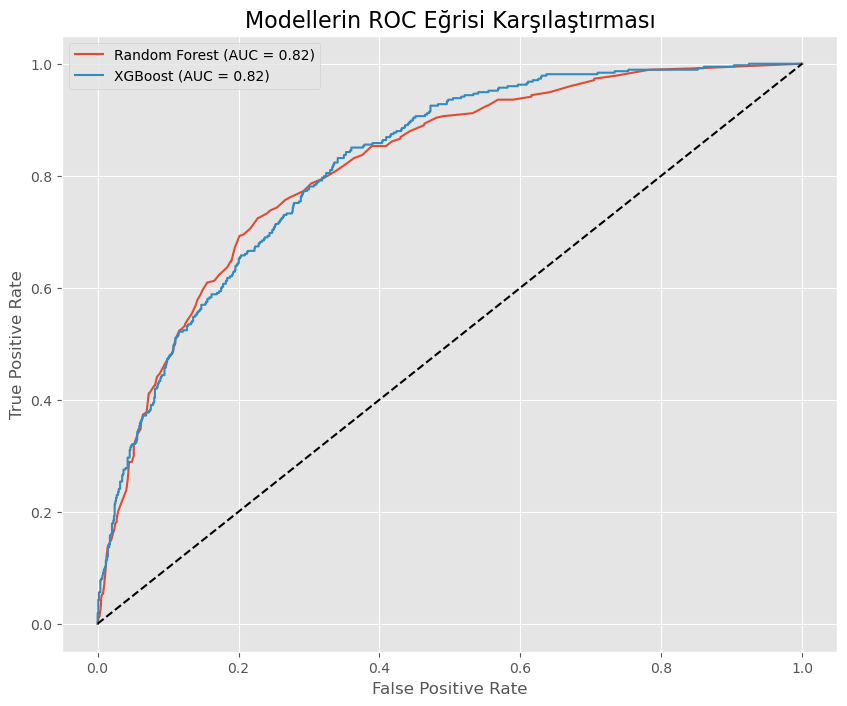

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

# Her iki model için de ROC eğrisi verilerini hesaplayalım
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# ROC Eğrilerini çizdirelim
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Rastgele tahmin çizgisi
plt.title('Modellerin ROC Eğrisi Karşılaştırması', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()
plt.show()